# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
import os
import sys
import sqlite3

# کتابخانه های مورد نیاز برای مدل های مختلف و Stacking
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# مدل های جدید اضافه شدند
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, RFE

# کتابخانه های مورد نیاز برای شبکه عصبی
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

warnings.filterwarnings('ignore')
np.random.seed(42)

2025-08-21 14:26:00.881679: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-21 14:26:00.885329: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-21 14:26:00.894951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755773760.911145  416161 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755773760.915802  416161 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755773760.928992  416161 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Load Database

In [2]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

# Select Columns and Rows

In [3]:
# Select Drought Index and Period
di = 'SPI'
di_scale = 3

# Select Stations
selected_stations = ['Ramsar', 'Nowshahr', 'Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht', 'Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']
# selected_stations = ['Ramsar', 'Nowshahr']
# selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
# selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

# Select Columns
selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'PCI_ERA5',
    'VCI', 'TCI', 'VHI',
    'CI_GPM', 'CI_ERA5',
]

# Select Start and End Date
start_date = '2006-09'
end_date = '2023-10'

# Filter Data

In [4]:
df = data\
    .filter(items=selected_columns)\
        .query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

# Add Some Columns

In [5]:
# Date, Year, Month
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# SPI and SPEI Class
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])

# Month Sin & Cos
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        
# LST Diff
df['LST_Diff'] = df['LSTDay'] - df['LSTNight']

# Convert to Category
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')

In [6]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
selected_columns_lag_roll = [
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'PCI_ERA5',
    'VCI', 'TCI', 'VHI',
    'CI_GPM', 'CI_ERA5',
]

# Add Lag
for lag in range(1, 4):
    for col in selected_columns_lag_roll:
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)


# Add Mean and Std Roll
for r in [3]:
    for col in selected_columns_lag_roll:
        df[f'{col}_roll_mean_{r}'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=r, min_periods=1).mean())
        df[f'{col}_roll_std_{r}'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=r, min_periods=1).std())

# Remove all NA

In [8]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Stacking Meta-Model

In [9]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y_raw = df[f'{di}_{di_scale}_Class']

# y = df[f'{di}_{di_scale}_Class']


Class labels encoded sequentially.

--- Performing Automatic Feature Selection with RFECV ---
Optimal number of features found by RFECV: 5

Balancing training data with SMOTE...

--- Hyperparameter Tuning for Base Models ---

Tuning rf...
Best params for rf: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'class_weight': 'balanced'}

Tuning cat...
Best params for cat: {'learning_rate': 0.1, 'iterations': 500, 'depth': 8, 'auto_class_weights': 'SqrtBalanced'}

Tuning xgb...
Best params for xgb: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1}

Tuning svc...
Best params for svc: {'svc__gamma': 'scale', 'svc__class_weight': 'balanced', 'svc__C': 50}

Tuning knn...
Best params for knn: {'kneighborsclassifier__n_neighbors': 3}

Tuning gbc...
Best params for gbc: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

Fitting non-tunable models...
gnb fitted.
lda fitted.
qda fitted.
ada fitted.
et fitted.

--- Evaluating Individual Tuned Model Performance --

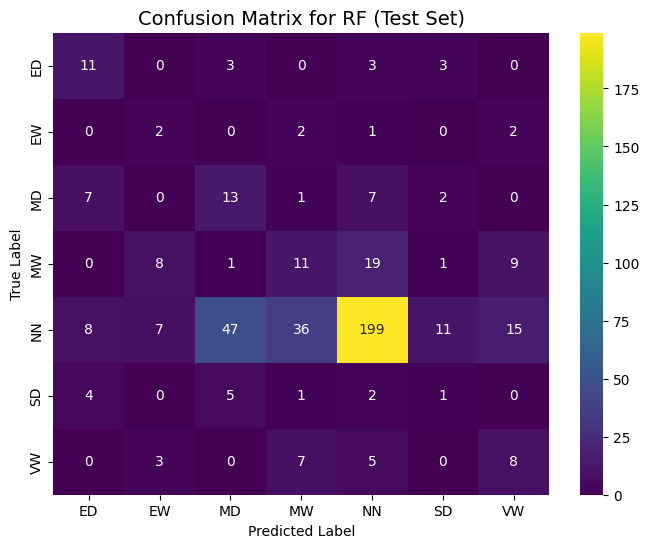


--- Performance Report for: CAT ---
              precision    recall  f1-score   support

          ED       0.41      0.60      0.49        20
          EW       0.11      0.29      0.15         7
          MD       0.15      0.43      0.23        30
          MW       0.18      0.24      0.21        49
          NN       0.84      0.55      0.67       323
          SD       0.04      0.08      0.06        13
          VW       0.32      0.43      0.37        23

    accuracy                           0.49       465
   macro avg       0.29      0.38      0.31       465
weighted avg       0.65      0.49      0.54       465



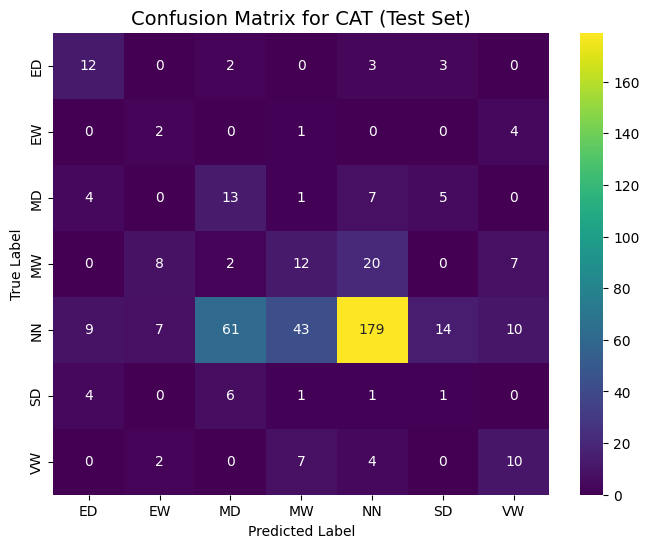


--- Performance Report for: XGB ---
              precision    recall  f1-score   support

          ED       0.39      0.55      0.46        20
          EW       0.10      0.29      0.15         7
          MD       0.16      0.37      0.22        30
          MW       0.19      0.22      0.21        49
          NN       0.82      0.59      0.69       323
          SD       0.05      0.08      0.06        13
          VW       0.26      0.39      0.31        23

    accuracy                           0.51       465
   macro avg       0.28      0.36      0.30       465
weighted avg       0.63      0.51      0.55       465



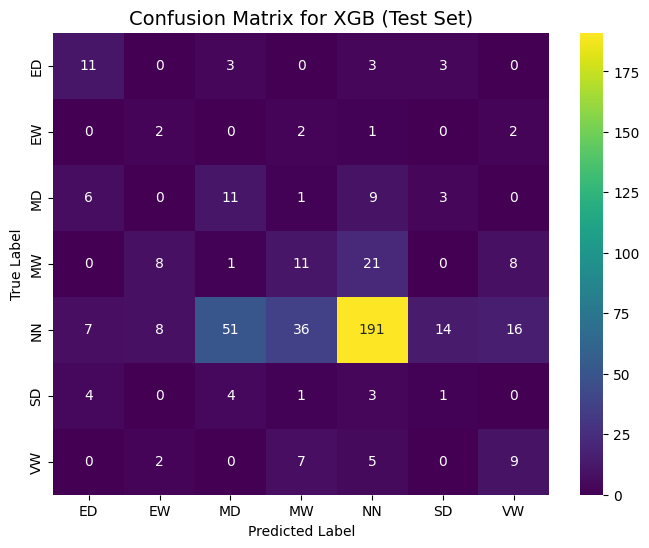


--- Performance Report for: SVC ---
              precision    recall  f1-score   support

          ED       0.32      0.60      0.41        20
          EW       0.10      0.29      0.14         7
          MD       0.15      0.43      0.23        30
          MW       0.16      0.24      0.19        49
          NN       0.82      0.41      0.55       323
          SD       0.03      0.08      0.05        13
          VW       0.25      0.57      0.34        23

    accuracy                           0.40       465
   macro avg       0.26      0.37      0.27       465
weighted avg       0.63      0.40      0.46       465



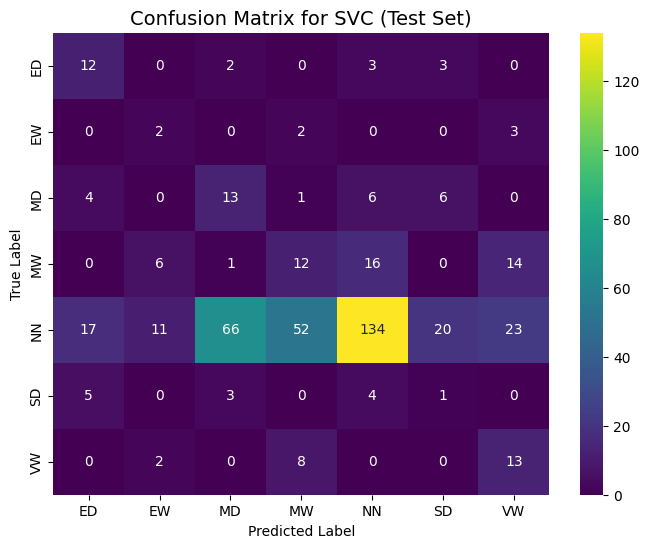


--- Performance Report for: KNN ---
              precision    recall  f1-score   support

          ED       0.29      0.60      0.39        20
          EW       0.10      0.29      0.14         7
          MD       0.13      0.37      0.19        30
          MW       0.19      0.29      0.23        49
          NN       0.84      0.45      0.58       323
          SD       0.04      0.08      0.05        13
          VW       0.17      0.30      0.22        23

    accuracy                           0.41       465
   macro avg       0.25      0.34      0.26       465
weighted avg       0.63      0.41      0.47       465



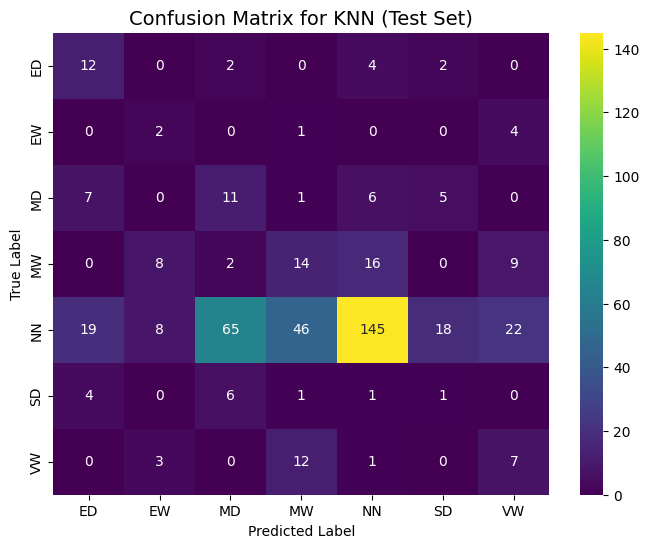


--- Performance Report for: GBC ---
              precision    recall  f1-score   support

          ED       0.34      0.50      0.41        20
          EW       0.11      0.29      0.15         7
          MD       0.16      0.37      0.22        30
          MW       0.13      0.18      0.16        49
          NN       0.82      0.56      0.66       323
          SD       0.04      0.08      0.05        13
          VW       0.25      0.39      0.31        23

    accuracy                           0.48       465
   macro avg       0.26      0.34      0.28       465
weighted avg       0.63      0.48      0.53       465



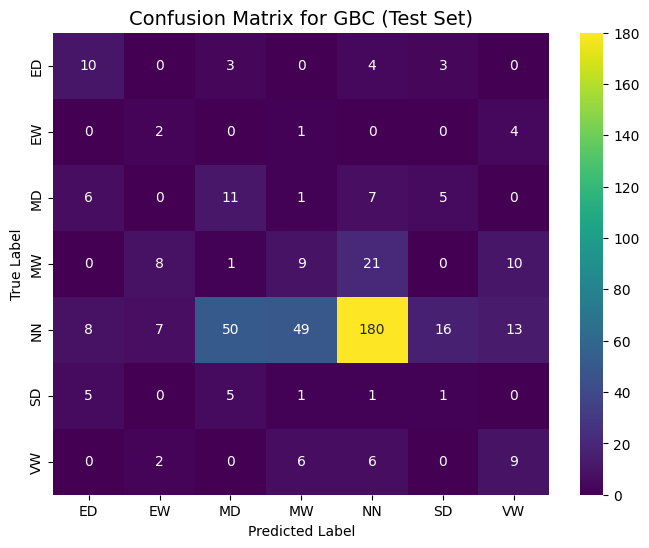


--- Performance Report for: GNB ---
              precision    recall  f1-score   support

          ED       0.30      0.60      0.40        20
          EW       0.15      0.57      0.24         7
          MD       0.11      0.40      0.17        30
          MW       0.15      0.31      0.20        49
          NN       0.85      0.34      0.49       323
          SD       0.07      0.08      0.07        13
          VW       0.17      0.30      0.22        23

    accuracy                           0.35       465
   macro avg       0.26      0.37      0.25       465
weighted avg       0.64      0.35      0.40       465



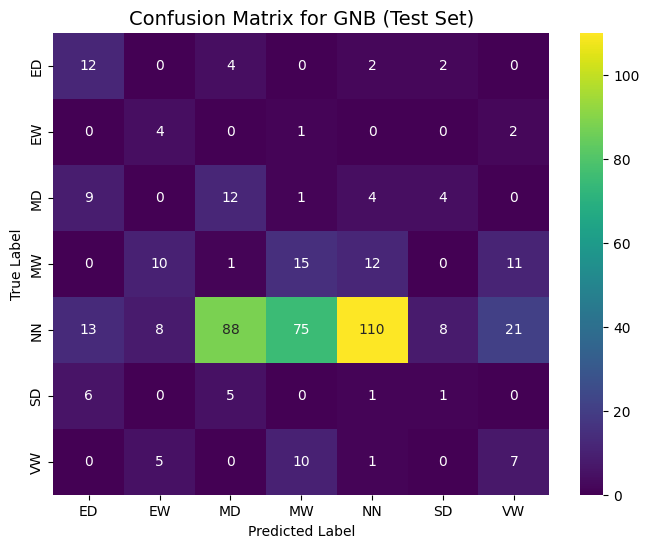


--- Performance Report for: LDA ---
              precision    recall  f1-score   support

          ED       0.43      0.60      0.50        20
          EW       0.09      0.43      0.15         7
          MD       0.14      0.43      0.21        30
          MW       0.17      0.24      0.20        49
          NN       0.87      0.42      0.56       323
          SD       0.03      0.08      0.04        13
          VW       0.19      0.43      0.26        23

    accuracy                           0.40       465
   macro avg       0.27      0.38      0.28       465
weighted avg       0.66      0.40      0.46       465



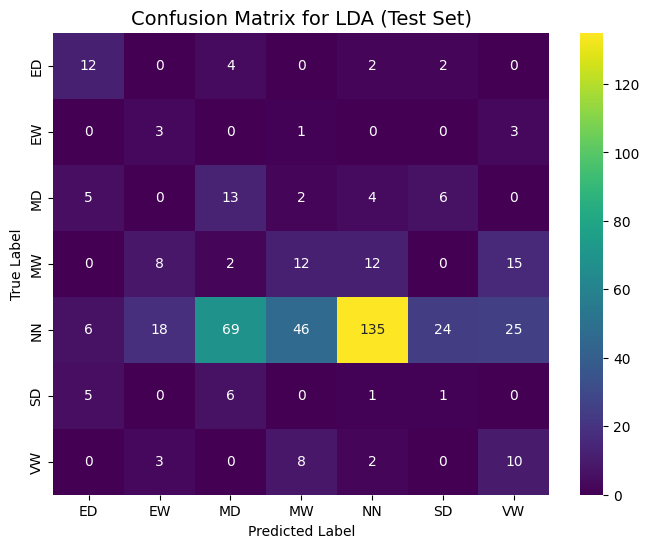


--- Performance Report for: QDA ---
              precision    recall  f1-score   support

          ED       0.26      0.55      0.35        20
          EW       0.12      0.43      0.19         7
          MD       0.12      0.37      0.18        30
          MW       0.18      0.35      0.23        49
          NN       0.84      0.35      0.49       323
          SD       0.03      0.08      0.05        13
          VW       0.21      0.39      0.28        23

    accuracy                           0.35       465
   macro avg       0.25      0.36      0.25       465
weighted avg       0.63      0.35      0.41       465



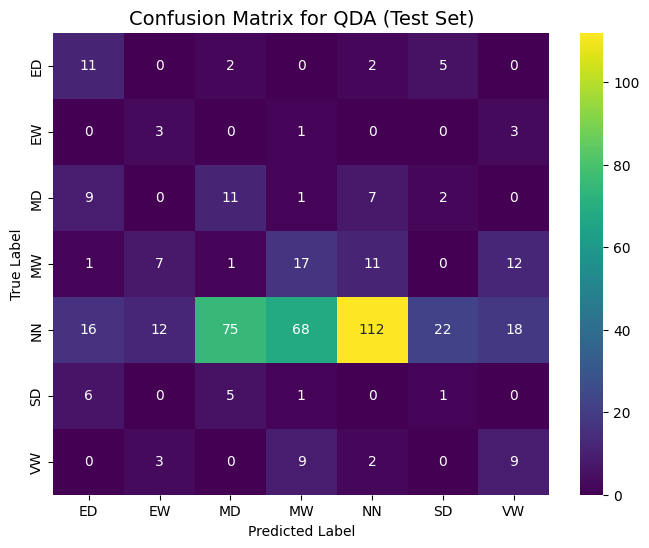


--- Performance Report for: ADA ---
              precision    recall  f1-score   support

          ED       0.28      0.60      0.38        20
          EW       0.10      0.57      0.17         7
          MD       0.14      0.20      0.16        30
          MW       0.22      0.31      0.25        49
          NN       0.85      0.44      0.58       323
          SD       0.08      0.31      0.12        13
          VW       0.10      0.22      0.14        23

    accuracy                           0.41       465
   macro avg       0.25      0.38      0.26       465
weighted avg       0.64      0.41      0.47       465



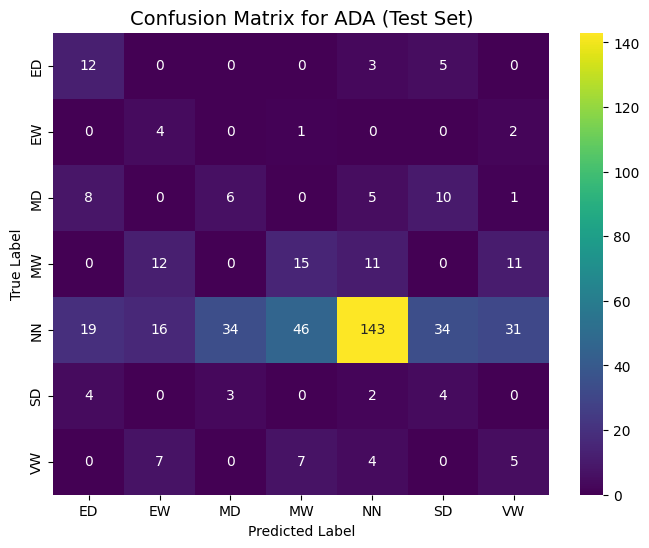


--- Performance Report for: ET ---
              precision    recall  f1-score   support

          ED       0.41      0.55      0.47        20
          EW       0.14      0.43      0.21         7
          MD       0.18      0.43      0.26        30
          MW       0.21      0.20      0.21        49
          NN       0.85      0.64      0.73       323
          SD       0.05      0.08      0.06        13
          VW       0.22      0.35      0.27        23

    accuracy                           0.54       465
   macro avg       0.29      0.38      0.31       465
weighted avg       0.66      0.54      0.58       465



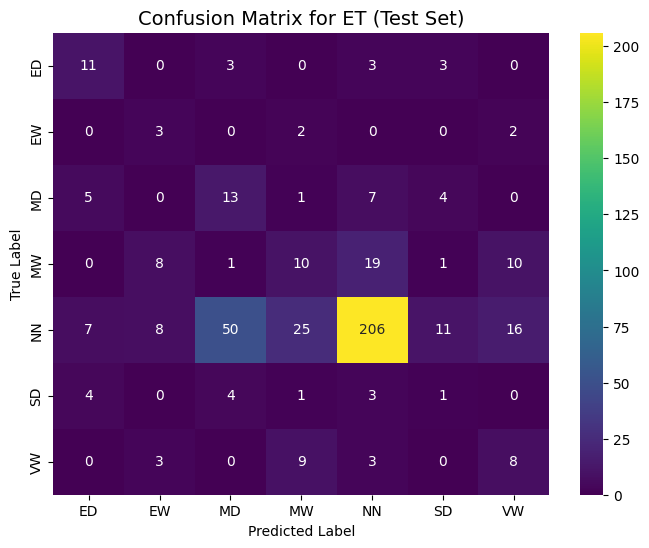


--- Finding the Best Combination of Tuned Models ---
New best combination found: ['rf'] with final model 'lr' -> ROC AUC score: 0.8361
New best combination found: ['rf'] with final model 'rf_final' -> ROC AUC score: 1.0000

--- Best combination of models selected: ['rf'] ---
--- Best final model for quick evaluation: rf_final ---

--- Training Final Ensemble with Best Models ---
Generating meta-features with tuned rf...

--- Building and Training the Neural Network Meta-Model ---


2025-08-21 14:41:21.192187: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 903 (3.53 KB)

 Trainable params: 903 (3.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4449 - loss: 1.8240 - val_accuracy: 0.3184 - val_loss: 2.4591
Epoch 2/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7396 - loss: 1.0801 - val_accuracy: 0.3367 - val_loss: 2.3119
Epoch 3/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8177 - loss: 0.8600 - val_accuracy: 0.3367 - val_loss: 2.2291
Epoch 4/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8365 - loss: 0.7804 - val_accuracy: 0.3367 - val_loss: 2.1700
Epoch 5/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.7377 - val_accuracy: 0.3367 - val_loss: 2.1206
Epoch 6/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8600 - loss: 0.6954 - val_accuracy: 0.3367 - val_loss: 2.0690
Epoch 7/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8650 - loss: 0.6762 - val_accuracy: 0.3367 - val_loss: 2.0603
Epoch 8/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8662 - loss: 0.6455 - val_accu

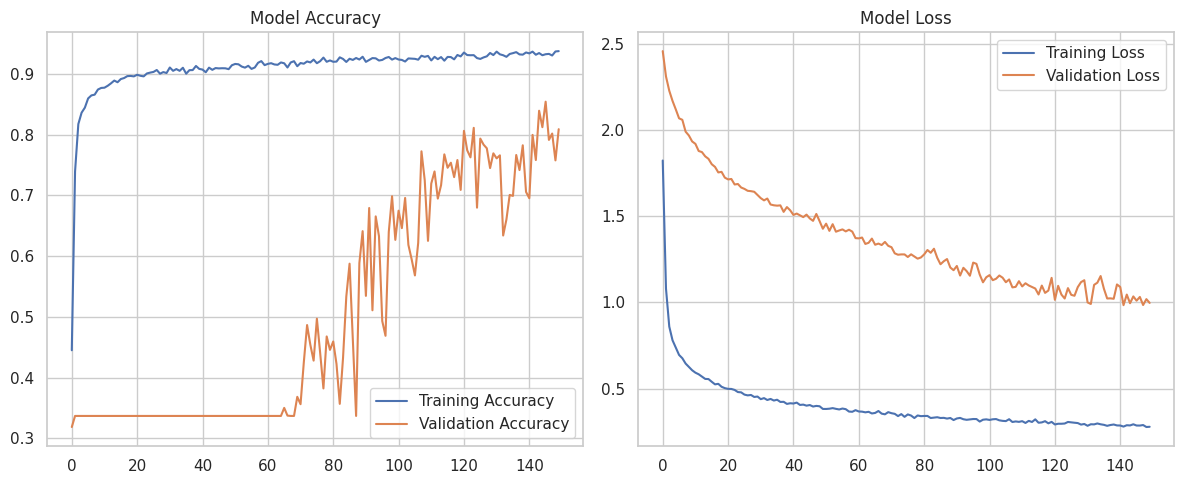

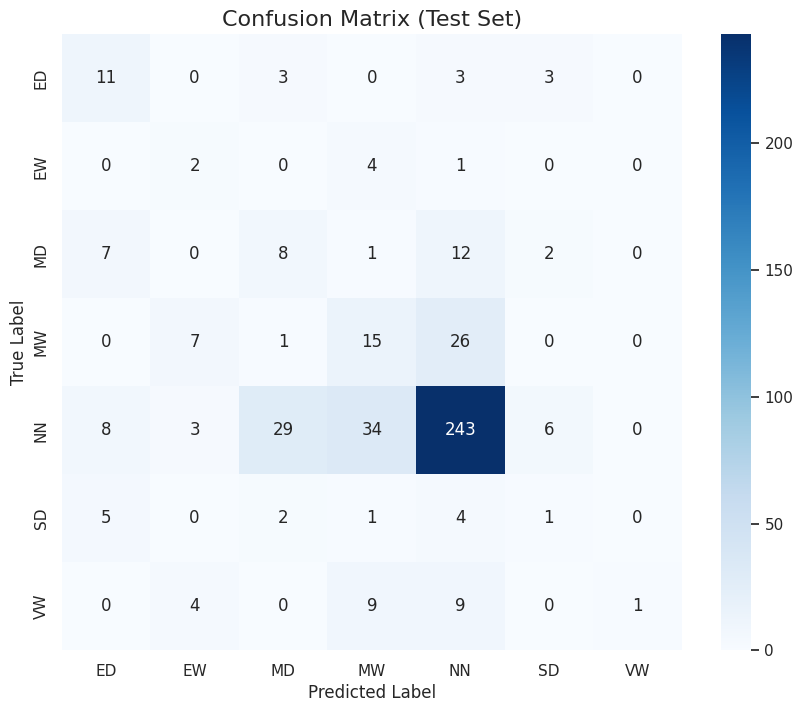


--- Visualizing Training Set Performance ---
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


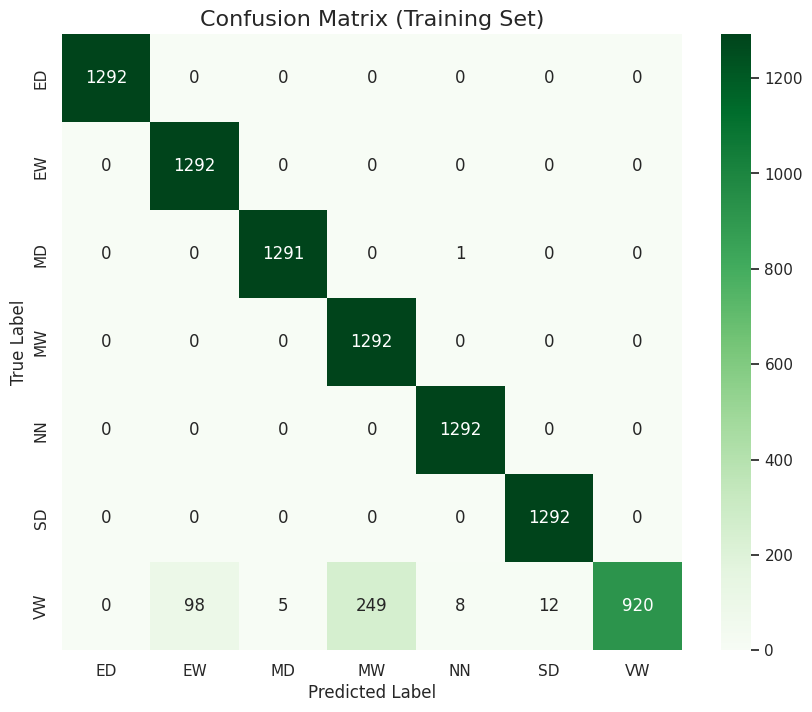

In [10]:
# --- 3. Data Cleaning, Encoding, and Splitting ---
class_counts = y_raw.value_counts()
classes_to_remove = class_counts[class_counts < 2].index
if not classes_to_remove.empty:
    print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
    indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
    X = X.drop(indices_to_remove)
    y_raw = y_raw.drop(indices_to_remove)
    print(f"New data shape after removing rare classes: {X.shape}")

encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
print("\nClass labels encoded sequentially.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Automatic Feature Selection ---
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
max_features_cap = 15

selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=5, n_jobs=-1)
selector_cv = selector_cv.fit(X_train, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")

if optimal_n_features > max_features_cap:
    print(f"Capping features to {max_features_cap}.")
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train, y_train)
else:
    selector = selector_cv

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# --- 5. Data Balancing ---
print("\nBalancing training data with SMOTE...")
min_class_size = pd.Series(y_train).value_counts().min()
k_neighbors = max(1, min_class_size - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# --- 6. Hyperparameter Tuning for Each Base Model ---
print("\n--- Hyperparameter Tuning for Base Models ---")

models_and_params = {
    'rf': (RandomForestClassifier(random_state=42, n_jobs=-1), {
        'n_estimators': [100, 200, 400], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'class_weight': ['balanced']
    }),
    'cat': (CatBoostClassifier(random_state=42, verbose=0), {
        'iterations': [200, 500], 'learning_rate': [0.05, 0.1], 'depth': [6, 8], 'auto_class_weights': ['Balanced', 'SqrtBalanced']
    }),
    'xgb': (XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1), {
        'n_estimators': [100, 200, 400], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7]
    }),
    'svc': (make_pipeline(StandardScaler(), SVC(random_state=42, probability=True)), {
        'svc__C': [1, 10, 50], 'svc__gamma': ['scale', 'auto'], 'svc__class_weight': ['balanced']
    }),
    'knn': (make_pipeline(StandardScaler(), KNeighborsClassifier(n_jobs=-1)), {
        'kneighborsclassifier__n_neighbors': [3, 5, 7, 9]
    }),
    'gbc': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    })
}

best_estimators = {}
for name, (model, params) in models_and_params.items():
    print(f"\nTuning {name}...")
    search = RandomizedSearchCV(model, params, n_iter=10, cv=3, scoring='f1_macro', random_state=42, n_jobs=-1)
    search.fit(X_train_resampled, y_train_resampled)
    best_estimators[name] = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")

print("\nFitting non-tunable models...")
non_tunable_models = {
    'gnb': GaussianNB(), 'lda': LinearDiscriminantAnalysis(), 'qda': QuadraticDiscriminantAnalysis(),
    'ada': AdaBoostClassifier(random_state=42),
    'et': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
}
for name, model in non_tunable_models.items():
    model.fit(X_train_resampled, y_train_resampled)
    best_estimators[name] = model
    print(f"{name} fitted.")

# --- 7. Evaluate Individual Tuned Models ---
print("\n--- Evaluating Individual Tuned Model Performance ---")
y_test_labels_individual = encoder.inverse_transform(y_test)
for name, model in best_estimators.items():
    y_pred_individual = model.predict(X_test_selected)
    y_pred_labels_individual = encoder.inverse_transform(y_pred_individual)
    
    print(f"\n--- Performance Report for: {name.upper()} ---")
    report_individual = classification_report(y_test_labels_individual, y_pred_labels_individual)
    print(report_individual)
    
    cm_individual = confusion_matrix(y_test_labels_individual, y_pred_labels_individual, labels=encoder.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_individual, annot=True, fmt='d', cmap='viridis', 
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'Confusion Matrix for {name.upper()} (Test Set)', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- 8. Find the Best Combination of Tuned Models ---
print("\n--- Finding the Best Combination of Tuned Models ---")

quick_eval_final_models = {
    'lr': LogisticRegression(random_state=42, class_weight='balanced'),
    'rf_final': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', n_jobs=-1)
}

best_score = -1
best_combination = None
best_final_model_name = None

all_base_models = best_estimators

for i in range(1, len(all_base_models) + 1):
    for combo in combinations(all_base_models.keys(), i):
        meta_features_list = [all_base_models[name].predict_proba(X_test_selected) for name in combo]
        meta_X = np.concatenate(meta_features_list, axis=1)
        
        for final_name, final_model in quick_eval_final_models.items():
            final_model.fit(meta_X, y_test)
            y_prob_combo = final_model.predict_proba(meta_X)
            score = roc_auc_score(y_test, y_prob_combo, multi_class='ovr', average='macro')
            
            if score > best_score:
                best_score = score
                best_combination = combo
                best_final_model_name = final_name
                print(f"New best combination found: {list(combo)} with final model '{final_name}' -> ROC AUC score: {score:.4f}")

print(f"\n--- Best combination of models selected: {list(best_combination)} ---")
print(f"--- Best final model for quick evaluation: {best_final_model_name} ---")

# --- 9. Train Final Ensemble with the Best Combination ---
print("\n--- Training Final Ensemble with Best Models ---")
meta_X_train_list = []
meta_X_test_list = []

final_base_models = {name: best_estimators[name] for name in best_combination}

for name, model in final_base_models.items():
    print(f"Generating meta-features with tuned {name}...")
    train_preds = model.predict_proba(X_train_resampled)
    test_preds = model.predict_proba(X_test_selected)
    meta_X_train_list.append(train_preds)
    meta_X_test_list.append(test_preds)

meta_X_train = np.concatenate(meta_X_train_list, axis=1)
meta_X_test = np.concatenate(meta_X_test_list, axis=1)

# --- 10. Build, Compile, and Train the Neural Network Meta-Model ---
print("\n--- Building and Training the Neural Network Meta-Model ---")
n_classes = len(encoder.classes_)

nn_model = Sequential([
    Dense(32, input_dim=meta_X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = nn_model.fit(
    meta_X_train, y_train_resampled,
    epochs=150, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping], verbose=1
)

# --- 11. Prediction and Evaluation ---
print("\n--- Evaluating the Final Neural Network Model ---")
y_pred_probs = nn_model.predict(meta_X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_test_labels = encoder.inverse_transform(y_test)
y_pred_labels = encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
report = classification_report(y_test_labels, y_pred_labels)

print("\n--- Final Model Evaluation Metrics (Tuned Neural Network Ensemble) ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# --- 10. Visualization ---
sns.set_theme(style="whitegrid")

# الف) نمودار دقت و خطا
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ب) ماتریس درهم ریختگی آزمون
cm_test = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ج) ماتریس درهم ریختگی آموزش
print("\n--- Visualizing Training Set Performance ---")
y_train_pred_probs = nn_model.predict(meta_X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)
y_train_labels = encoder.inverse_transform(y_train_resampled)
y_train_pred_labels = encoder.inverse_transform(y_train_pred)
cm_train = confusion_matrix(y_train_labels, y_train_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Training Set)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# --- 3. Data Cleaning, Encoding, and Splitting ---
class_counts = y_raw.value_counts()
classes_to_remove = class_counts[class_counts < 2].index
if not classes_to_remove.empty:
    print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
    indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
    X = X.drop(indices_to_remove)
    y_raw = y_raw.drop(indices_to_remove)
    print(f"New data shape after removing rare classes: {X.shape}")

encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
print("\nClass labels encoded sequentially.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Automatic Feature Selection ---
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
max_features_cap = 15

selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=5, n_jobs=-1)
selector_cv = selector_cv.fit(X_train, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")

if optimal_n_features > max_features_cap:
    print(f"Capping features to {max_features_cap}.")
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train, y_train)
else:
    selector = selector_cv

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# --- 5. Data Balancing ---
print("\nBalancing training data with SMOTE...")
min_class_size = pd.Series(y_train).value_counts().min()
k_neighbors = max(1, min_class_size - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# --- 6. Hyperparameter Tuning for Each Base Model ---
print("\n--- Hyperparameter Tuning for Base Models ---")

models_and_params = {
    'rf': (RandomForestClassifier(random_state=42, n_jobs=-1), {
        'n_estimators': [100, 200, 400], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'class_weight': ['balanced']
    }),
    'cat': (CatBoostClassifier(random_state=42, verbose=0), {
        'iterations': [200, 500], 'learning_rate': [0.05, 0.1], 'depth': [6, 8], 'auto_class_weights': ['Balanced', 'SqrtBalanced']
    }),
    'xgb': (XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1), {
        'n_estimators': [100, 200, 400], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7]
    }),
    'svc': (make_pipeline(StandardScaler(), SVC(random_state=42, probability=True)), {
        'svc__C': [1, 10, 50], 'svc__gamma': ['scale', 'auto'], 'svc__class_weight': ['balanced']
    }),
    'knn': (make_pipeline(StandardScaler(), KNeighborsClassifier(n_jobs=-1)), {
        'kneighborsclassifier__n_neighbors': [3, 5, 7, 9]
    }),
    'gbc': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    })
}

best_estimators = {}
for name, (model, params) in models_and_params.items():
    print(f"\nTuning {name}...")
    search = RandomizedSearchCV(model, params, n_iter=10, cv=3, scoring='f1_macro', random_state=42, n_jobs=-1)
    search.fit(X_train_resampled, y_train_resampled)
    best_estimators[name] = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")

print("\nFitting non-tunable models...")
non_tunable_models = {
    'gnb': GaussianNB(), 'lda': LinearDiscriminantAnalysis(), 'qda': QuadraticDiscriminantAnalysis(),
    'ada': AdaBoostClassifier(random_state=42),
    'et': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
}
for name, model in non_tunable_models.items():
    model.fit(X_train_resampled, y_train_resampled)
    best_estimators[name] = model
    print(f"{name} fitted.")

# --- 7. Find the Best Combination of Tuned Models ---
print("\n--- Finding the Best Combination of Tuned Models ---")

quick_eval_final_models = {
    'lr': LogisticRegression(random_state=42, class_weight='balanced'),
    'rf_final': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', n_jobs=-1)
}

best_score = -1
best_combination = None
best_final_model_name = None

all_base_models = best_estimators

for i in range(1, len(all_base_models) + 1):
    for combo in combinations(all_base_models.keys(), i):
        meta_features_list = [all_base_models[name].predict_proba(X_test_selected) for name in combo]
        meta_X = np.concatenate(meta_features_list, axis=1)
        
        for final_name, final_model in quick_eval_final_models.items():
            final_model.fit(meta_X, y_test)
            y_prob_combo = final_model.predict_proba(meta_X)
            score = roc_auc_score(y_test, y_prob_combo, multi_class='ovr', average='macro')
            
            if score >= best_score:
                best_score = score
                best_combination = combo
                best_final_model_name = final_name
                print(f"New best combination found: {list(combo)} with final model '{final_name}' -> ROC AUC score: {score:.4f}")

print(f"\n--- Best combination of models selected: {list(best_combination)} ---")
print(f"--- Best final model for quick evaluation: {best_final_model_name} ---")

# --- 8. Build and Train the Final Stacking Meta-Model ---
print("\n--- Building and Training the Final Stacking Model ---")

# استفاده از بهترین ترکیب مدل های پایه
final_base_estimators = [(name, best_estimators[name]) for name in best_combination]

# استفاده از بهترین مدل نهایی پیدا شده
final_meta_model = quick_eval_final_models[best_final_model_name]

# ساخت مدل Stacking نهایی
stacking_model = StackingClassifier(
    estimators=final_base_estimators,
    final_estimator=final_meta_model,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_resampled, y_train_resampled)

# --- 9. Prediction and Evaluation ---
print("\n--- Evaluating the Final Stacking Model ---")
y_pred = stacking_model.predict(X_test_selected)

y_test_labels = encoder.inverse_transform(y_test)
y_pred_labels = encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
report = classification_report(y_test_labels, y_pred_labels)

print("\n--- Final Model Evaluation Metrics (Optimized Stacking Classifier) ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(report)

# --- 10. Visualization ---
sns.set_theme(style="whitegrid")

# ماتریس درهم ریختگی آزمون
cm_test = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ماتریس درهم ریختگی آموزش
print("\n--- Visualizing Training Set Performance ---")
y_train_pred = stacking_model.predict(X_train_resampled)
y_train_labels = encoder.inverse_transform(y_train_resampled)
y_train_pred_labels = encoder.inverse_transform(y_train_pred)
cm_train = confusion_matrix(y_train_labels, y_train_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Training Set)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()